In [1]:
from os import path
from requests import get
from bs4 import BeautifulSoup
import os
import pandas as pd
import numpy as np
import re
import unicodedata
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns

# Acquire Functions

- Used these to play around. Do not use these for final notebook. Use Kevin's!

In [2]:
def find_file(
    file_name='path/file.txt',
    cache=False,
    cache_age=None
    ):

    if cache==False:
        return None
    
    return path.exists(file_name)

In [3]:
def get_soup(
    url='https://github.com/search?o=desc&p=1&q=advent+of+code&s=stars&type=Repositories',
    headers={'User-Agent': 'Nothing suspicious'},
    file_name='soupfiles/gitsearch.txt',
    cache=False,
    cache_age=None,
    soup_slurper='*'
):
    # if we already have the data, read it locally
    file_found = find_file(file_name=file_name, cache=cache, cache_age=cache_age)
    if file_found:
        with open(file_name) as f:
            return BeautifulSoup(f.read())

    # otherwise go fetch the data
    response = get(url, headers=headers)
    soup = BeautifulSoup(response.text)
    slurps = soup.select(soup_slurper)

    # save it for next time
    with open(file_name, 'w') as f:
        f.write(str(slurps[0]))
        if len(slurps)>1:
            for slurp in slurps[1:]:
                f.write('\n' + str(slurp))
        
    with open(file_name) as f:    
        soup = BeautifulSoup(f.read())
#     pd.to_csv(slurps, header=None, index=False)

    return soup

In [4]:
soup = get_soup(url='https://github.com/search?o=desc&p=1&q=advent+of+code&s=stars&type=Repositories', soup_slurper='.repo-list-item')

In [5]:
def all_repositories():
    page = str(range(1,21))
    repo_list = []
    for p in page:
        repo_list.extend(get_links_from_page('https://github.com/search?o=desc&p='+p+'&q=advent+of+code&s=stars&type=Repositories'))
        return repo_list

In [6]:
def get_links_from_page(url):
    soup = get_soup(
    url=url,
    cache=True,
    soup_slurper='.repo-list-item a',
    file_name='soupfiles/gitsearch.txt'
)

# Prepare

## Functions

In [7]:
def normalize(string):
    # lower case the string
    string = string.lower()

    # replace new lines with an empty space
    string = re.sub(r'\n',' ',string)
    
    # normalize unicode characters
    string = unicodedata.normalize('NFKD', string).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # replace . with space
    string = re.sub(r'\.',' ',string)
    
    # replace c++ th c plus plus
    string = re.sub(r'c\+\+','cplusplus',string)

    # replace c+ with c plus
    string = re.sub(r'c\+','cplus ',string)

    # replace c# with c sharp
    string = re.sub(r'c#','csharp ',string)

    # replace f# with f sharp
    string = re.sub(r'f#','fsharp ',string)
    
    # replace extra spaces with only one space
    string = re.sub(r'\s+',' ',string)

    # remove special characters with regex
    string = re.sub(r'[^a-z0-9\s]','', string)
    
    return string

In [8]:
def stem(string):
    ps = nltk.porter.PorterStemmer()
    stems = [ps.stem(word) for word in string.split()]
    string_of_stems = ' '.join(stems)
    return string_of_stems

In [9]:
def lemmatize(string):
    wnl = nltk.stem.WordNetLemmatizer()
    lemmas = [wnl.lemmatize(word) for word in string.split()]
    string_of_lemmas = ' '.join(lemmas)
    return string_of_lemmas

In [10]:
def tokenize(string):
    tokenizer = nltk.tokenize.ToktokTokenizer()
    return tokenizer.tokenize(string, return_str=True)

In [11]:
def remove_stopwords(tokenized_string, extra_words=['advent', 'of','code', 'aoc', 'day', 'solution', 'httpsgithub','githubhttpsimg','hpphttpsgithub','httpsadventofcode'], exclude_words=[]):
    words = tokenized_string.split()
    stopword_list = stopwords.words('english')

    # remove the excluded words from the stopword list
    stopword_list = set(stopword_list) - set(exclude_words)

    # add in the user specified extra words
    stopword_list = stopword_list.union(set(extra_words))

    filtered_words = [w for w in words if w not in stopword_list]
    final_string = " ".join(filtered_words)
    return final_string

### Read in json file containing repos and content

In [12]:
# read in content as json and save as dataframe
df = pd.read_json('data.json')

In [13]:
type(df)

pandas.core.frame.DataFrame

In [14]:
# preview data
df.shape

(200, 3)

In [15]:
df.head(20)

,language,readme_contents,repo
0,Python,# Awesome Advent of Code\n\nThis is a collecti...,Bogdanp/awesome-advent-of-code
1,Rust,BurntSushi's 2018 Advent of Code solutions\n==...,BurntSushi/advent-of-code
2,Coq,Advent of Code 2018 in Coq\n==================...,Lysxia/advent-of-coq-2018
3,Python,# Advent of Code 2018\n\nMy solutions to the A...,fogleman/AdventOfCode2018
4,Haskell,Advent of Code 2018\n===================\n\n*[...,mstksg/advent-of-code-2018
5,C++,# advent2018-fast\n\n[Advent of Code 2018](htt...,Voltara/advent2018-fast
6,Python,Advent of Code data\n===================\n\n|p...,wimglenn/advent-of-code-data
7,Python,Advent of Code\n==============\n\nThis is a co...,ChrisPenner/Advent-Of-Code-Polyglot
8,Python,# Advent of Other People's Code\nFetches rando...,jaksi/advent-of-other-peoples-code
9,Python,using Neural Networks (SSD) on Tensorflow.\n\n...,molyswu/hand_detection


### Remove repos with no readme content. There are 28 of them.

In [16]:
df = df.dropna()
len(df)

172

### Create new columns which show readme content normalized, stemmed, and lemmatized

In [17]:
df = df.assign(normalized = df.readme_contents.apply(normalize))
df = df.assign(stemmed = df.normalized.apply(stem))
df = df.assign(lemmatized = df.normalized.apply(lemmatize))

In [18]:
# preview results to decide which technique to use when reducing form of words (lemmatize vs stemming)
df

,language,readme_contents,repo,normalized,stemmed,lemmatized
0,Python,# Awesome Advent of Code\n\nThis is a collecti...,Bogdanp/awesome-advent-of-code,awesome advent of code this is a collection o...,awesom advent of code thi is a collect of awes...,awesome advent of code this is a collection of...
1,Rust,BurntSushi's 2018 Advent of Code solutions\n==...,BurntSushi/advent-of-code,burntsushis 2018 advent of code solutions i c...,burntsushi 2018 advent of code solut i chose t...,burntsushis 2018 advent of code solution i cho...
2,Coq,Advent of Code 2018 in Coq\n==================...,Lysxia/advent-of-coq-2018,advent of code 2018 in coq this repository co...,advent of code 2018 in coq thi repositori cont...,advent of code 2018 in coq this repository con...
3,Python,# Advent of Code 2018\n\nMy solutions to the A...,fogleman/AdventOfCode2018,advent of code 2018 my solutions to the adven...,advent of code 2018 my solut to the advent of ...,advent of code 2018 my solution to the advent ...
4,Haskell,Advent of Code 2018\n===================\n\n*[...,mstksg/advent-of-code-2018,advent of code 2018 2016 2017 2018 2019 20...,advent of code 2018 2016 2017 2018 2019 2016 h...,advent of code 2018 2016 2017 2018 2019 2016 h...
5,C++,# advent2018-fast\n\n[Advent of Code 2018](htt...,Voltara/advent2018-fast,advent2018fast advent of code 2018httpadvento...,advent2018fast advent of code 2018httpadventof...,advent2018fast advent of code 2018httpadventof...
6,Python,Advent of Code data\n===================\n\n|p...,wimglenn/advent-of-code-data,advent of code data pyversions pypi womm trav...,advent of code data pyvers pypi womm travi cov...,advent of code data pyversions pypi womm travi...
7,Python,Advent of Code\n==============\n\nThis is a co...,ChrisPenner/Advent-Of-Code-Polyglot,advent of code this is a collection of advent...,advent of code thi is a collect of advent of c...,advent of code this is a collection of advent ...
8,Python,# Advent of Other People's Code\nFetches rando...,jaksi/advent-of-other-peoples-code,advent of other peoples code fetches random s...,advent of other peopl code fetch random solut ...,advent of other people code fetch random solut...
9,Python,using Neural Networks (SSD) on Tensorflow.\n\n...,molyswu/hand_detection,using neural networks ssd on tensorflow this r...,use neural network ssd on tensorflow thi repo ...,using neural network ssd on tensorflow this re...


In [19]:
df.repo.value_counts()

ksmithut/advent-of-code               2
roman01la/advent-of-code-2018         2
mikasjp/adventofcode2017              1
BartoszMilewski/AdventOfCode18        1
Voltara/advent2018-fast               1
hsz/AdventOfCode2015                  1
badouralix/advent-of-code-2018        1
borkdude/aoc2017                      1
dlew/aoc-2017                         1
markheath/advent-of-code-js           1
jcazevedo/advent-of-code-2018         1
jaksi/advent-of-other-peoples-code    1
willkill07/AdventOfCode2016           1
tginsberg/advent-2018-kotlin          1
ttencate/aoc2016                      1
AlexeSimon/adventofcode               1
danthedaniel/Advent-of-Code-2017      1
emiflake/Advent-of-Code-2019          1
liuyubobobo/Play-Advent-of-Code       1
BartMassey/advent-of-code-2016        1
bhauman/advent-of-clojure             1
taylorwood/advent-of-code             1
Dementophobia/advent-of-code-2019     1
joelgrus/advent2017                   1
derNiklaas/Advent-of-Code-2019        1


In [20]:
# choose lemmatize and proceed forward with tokenization and stop words

In [21]:
# create new column called prepped which takes the lemmatized column and passes it through the tokenize function and remove_stopwords function
df = df.assign(prepped = df.lemmatized.apply(tokenize).apply(remove_stopwords))

In [22]:
df.head(10)

,language,readme_contents,repo,normalized,stemmed,lemmatized,prepped
0,Python,# Awesome Advent of Code\n\nThis is a collecti...,Bogdanp/awesome-advent-of-code,awesome advent of code this is a collection o...,awesom advent of code thi is a collect of awes...,awesome advent of code this is a collection of...,awesome collection awesome resource related ye...
1,Rust,BurntSushi's 2018 Advent of Code solutions\n==...,BurntSushi/advent-of-code,burntsushis 2018 advent of code solutions i c...,burntsushi 2018 advent of code solut i chose t...,burntsushis 2018 advent of code solution i cho...,burntsushis 2018 chose write year rust dont pa...
2,Coq,Advent of Code 2018 in Coq\n==================...,Lysxia/advent-of-coq-2018,advent of code 2018 in coq this repository co...,advent of code 2018 in coq thi repositori cont...,advent of code 2018 in coq this repository con...,2018 coq repository contains 2018 com2018 form...
3,Python,# Advent of Code 2018\n\nMy solutions to the A...,fogleman/AdventOfCode2018,advent of code 2018 my solutions to the adven...,advent of code 2018 my solut to the advent of ...,advent of code 2018 my solution to the advent ...,2018 2018 problem check blog post explains wor...
4,Haskell,Advent of Code 2018\n===================\n\n*[...,mstksg/advent-of-code-2018,advent of code 2018 2016 2017 2018 2019 20...,advent of code 2018 2016 2017 2018 2019 2016 h...,advent of code 2018 2016 2017 2018 2019 2016 h...,2018 2016 2017 2018 2019 2016 commstksgadvento...
5,C++,# advent2018-fast\n\n[Advent of Code 2018](htt...,Voltara/advent2018-fast,advent2018fast advent of code 2018httpadvento...,advent2018fast advent of code 2018httpadventof...,advent2018fast advent of code 2018httpadventof...,advent2018fast 2018httpadventofcode com2018 op...
6,Python,Advent of Code data\n===================\n\n|p...,wimglenn/advent-of-code-data,advent of code data pyversions pypi womm trav...,advent of code data pyvers pypi womm travi cov...,advent of code data pyversions pypi womm travi...,data pyversions pypi womm travis coverall pyve...
7,Python,Advent of Code\n==============\n\nThis is a co...,ChrisPenner/Advent-Of-Code-Polyglot,advent of code this is a collection of advent...,advent of code thi is a collect of advent of c...,advent of code this is a collection of advent ...,collection codehttpadventofcode com many diffe...
8,Python,# Advent of Other People's Code\nFetches rando...,jaksi/advent-of-other-peoples-code,advent of other peoples code fetches random s...,advent of other peopl code fetch random solut ...,advent of other people code fetch random solut...,people fetch random specified codehttpsadvento...
9,Python,using Neural Networks (SSD) on Tensorflow.\n\n...,molyswu/hand_detection,using neural networks ssd on tensorflow this r...,use neural network ssd on tensorflow thi repo ...,using neural network ssd on tensorflow this re...,using neural network ssd tensorflow repo docum...


# Explore

In [23]:
# isolate language and prepped columns
df = df.drop(columns={'readme_contents','repo','normalized', 'stemmed', 'lemmatized'})

In [24]:
df.prepped[15]

'2019 file generated build script build h 2016 2017 2018 2019 2016 commstksgadventofcode2016 2017 commstksgadventofcode2017 2018 commstksgadventofcode2018 wonderful time year 2019aoc haskell along automated fetching testing running environment powered adventofcodeapi library interactive development environment runnerbench markerviewertester ha pulled heredev implemented fork reflection check reflection r feedrss package haddockshaddock info com2019 haddock httpsmstksg github ioadventofcode2019 adventofcodeapi httpshackage haskell orgpackageadventofcodeapi dev commstksgadventofcodedev reflection benchmarksreflections available r feedrss r httpfeeds feedburner comjleadventofcode2019 challenge reflection rendered benchmark 1 xd01r xd01g xd01h xd01b 2 xd02r xd02g xd02h xd02b 3 xd03r xd03g xd03h xd03b 4 xd04r xd04g xd04h xd04b 5 6 xd06r xd06g xd06h xd06b 7 8 xd08r xd08g xd08h xd08b 9 10 xd10r xd10g xd10h xd10b 11 xd11r xd11g xd11h xd11b 12 13 14 15 16 17 18 19 20 21 22 23 24 25 rendered lin

### How many repos of each language exist?

In [25]:
df.language.value_counts(normalize=False)

Python         29
Haskell        26
JavaScript     20
Rust           11
Clojure        10
Java            8
Ruby            7
C++             6
Kotlin          6
Elixir          5
Scala           5
Go              5
OCaml           4
C#              4
C               3
Pony            2
HTML            2
Elm             2
TypeScript      1
Eiffel          1
APL             1
Crystal         1
Racket          1
Perl            1
F#              1
Mathematica     1
Shell           1
Swift           1
Reason          1
PHP             1
PureScript      1
Coq             1
Nim             1
Haxe            1
TSQL            1
Name: language, dtype: int64

### What percentage is this?

In [26]:
df.language.value_counts(normalize=True)

Python         0.168605
Haskell        0.151163
JavaScript     0.116279
Rust           0.063953
Clojure        0.058140
Java           0.046512
Ruby           0.040698
C++            0.034884
Kotlin         0.034884
Elixir         0.029070
Scala          0.029070
Go             0.029070
OCaml          0.023256
C#             0.023256
C              0.017442
Pony           0.011628
HTML           0.011628
Elm            0.011628
TypeScript     0.005814
Eiffel         0.005814
APL            0.005814
Crystal        0.005814
Racket         0.005814
Perl           0.005814
F#             0.005814
Mathematica    0.005814
Shell          0.005814
Swift          0.005814
Reason         0.005814
PHP            0.005814
PureScript     0.005814
Coq            0.005814
Nim            0.005814
Haxe           0.005814
TSQL           0.005814
Name: language, dtype: float64

### What are the most common words in READMEs?

In [27]:
# get all text as a string
all_text = " ".join(df.prepped)
# convert to a list of words
all_words = all_text.split()

In [28]:
raw_count = pd.Series(all_words).value_counts()
raw_count.head(15)

run        225
shield     215
1          214
last       180
svg        170
commit     169
input      165
2          156
2017       156
part       151
test       128
py         128
puzzle     124
problem    119
hpp        119
dtype: int64

Text(0.5, 1.0, '10 most common words')

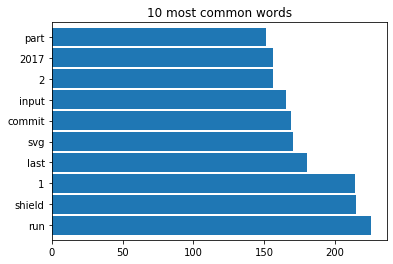

In [29]:
raw_count.sort_values(ascending=False)[0:10].plot.barh(width=.9)
plt.title('10 most common words')

### How does this look for popular languages?

#### Python

In [30]:
python_text = " ".join(df[df.language == "Python"].prepped)
python_words = python_text.split()

In [31]:
python_count = pd.Series(python_words).value_counts()
python_count.head(15)

shield      169
svg         168
last        166
commit      165
py           81
part         42
python       35
run          31
hand         30
image        28
input        27
training     27
model        26
2            25
1            24
dtype: int64

Text(0.5, 1.0, 'Python 10 most common words')

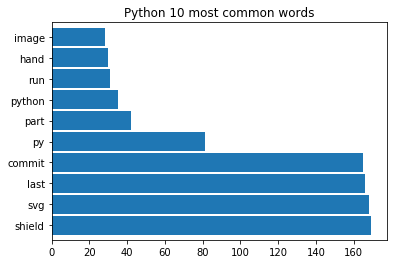

In [32]:
python_count.sort_values(ascending=False)[0:10].plot.barh(width=.9)
plt.title('Python 10 most common words')

#### Haskell

In [33]:
haskell_text = " ".join(df[df.language == "Haskell"].prepped)
haskell_words = haskell_text.split()

In [34]:
haskell_count = pd.Series(haskell_words).value_counts()
haskell_count.head(15)

h                                                 62
challenge                                         57
1                                                 52
commstksgadventofcode2017blobmasterreflections    51
haskell                                           42
test                                              40
0                                                 39
run                                               38
github                                            38
httpsmstksg                                       36
input                                             34
html                                              34
commstksgadventofcode2018blobmasterreflections    32
answer                                            28
reflection                                        28
dtype: int64

Text(0.5, 1.0, 'Haskell 10 most common words')

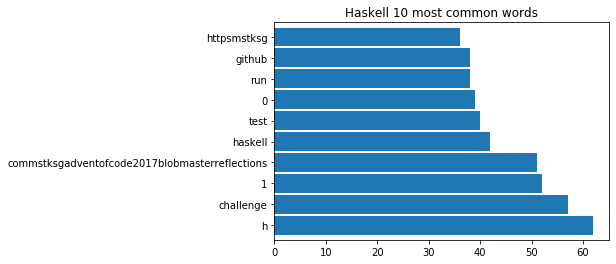

In [35]:
haskell_count.sort_values(ascending=False)[0:10].plot.barh(width=.9)
plt.title('Haskell 10 most common words')

#### JavaScript

In [36]:
javascript_text = " ".join(df[df.language == "JavaScript"].prepped)
javascript_words = javascript_text.split()

In [37]:
javascript_count = pd.Series(javascript_words).value_counts()
javascript_count.head(15)

star                46
j                   43
run                 42
puzzle              37
year                34
test                32
adventofcode        28
com                 28
npm                 28
input               27
httpadventofcode    25
configuration       22
file                20
part                18
see                 18
dtype: int64

Text(0.5, 1.0, 'JavaScript 10 most common words')

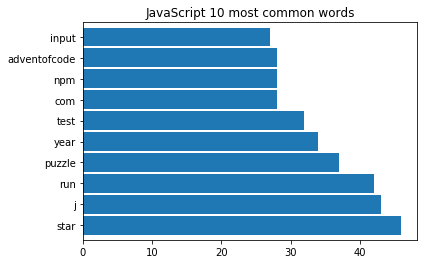

In [38]:
javascript_count.sort_values(ascending=False)[0:10].plot.barh(width=.9)
plt.title('JavaScript 10 most common words')

### Does the length of the README vary by programming language?